Welcome to my Capstone project for the IBM Data Science Professional Certification course on [Coursera](https://www.coursera.org/professional-certificates/ibm-data-science). My name is Tyler Kuromiya Parker, and this particular project will focus on using location data. To see more of my work, please check out my github profile located [here](https://www.github.com/tylerkkp), or my [website](https://www.tkkp.dev)

# IBM Data Science Capstone
## Week 4 - Problem Statement

Beer tourism is becoming increasingly common, and (fortunately) there is an abundance of choices for destinations. According to [this article](https://fortune.com/2019/08/06/new-craft-breweries-2019-data/), over 1,000 opened in 2018. That's a bit less than 3 per day! One of the more popular cities for beer tourism is Portland, Oregon. I went to college in Portland, but was underage and did not have the palate for good beer at the time. However, in the years since leaving Portland, I've become increasingly involved in the craft beer industry. Most recently, I started contributing to the OpenBreweryDB project, which seeks to catalog craft breweries across the USA and the world (currently including England and Scotland, although additional countries are anticipated in the future). 

As with many large cities, Portland has quite a few distinct neighborhoods, each with its own unique personality and characteristics. It is also an interesting city in that it is bisected by a river. The industrial and business districts are mostly on the West side of the river, and the neighborhoods are to the East. Breweries are all over the place. However, our aim with this project will be to find the _best_ neighborhood for beer - a rather high honor in a city with so many great breweries.

## The Data

In this project I will be looking at the neighborhoods as defined on the City of Portland Open Data portal [here](https://gis-pdx.opendata.arcgis.com/datasets/neighborhoods-regions?geometry=-123.656%2C45.374%2C-121.678%2C45.711). I will also be using the [OpenBreweryDB](https://www.openbrewerydb.org/) dataset, either through directly downloading the dataset, or using the API. I want to do a couple of analyses. In the spirit of 'Battle of Neighborhoods', I want to see which neighborhood can claim:

1. The most breweries
2. The 'best' breweries based on Foursquare reviews
3. Whatever else I can see from the initial exploratory analysis

The OpenBreweryDB dataset has a number of interesting datapoints which could provide some insights. For example, the predominant 'type' of brewery in a neighborhood. Brewpubs and other similar establishments would likely be more prevalent in tourist areas, and larger breweries would be found in more industrial areas where land and rent are cheaper. I would expect Nano and Micro Breweries to be in neighborhoods since they could be sustained by a small local population. My analysis will help determine if my assumptions hold true. 

In [31]:
!pip install geopandas
!pip install geojson

import pandas as pd
import geopandas as gpd
import numpy as np
import folium
import matplotlib.pyplot as plt
import geojson

## Data Sources
First, we need to get some data. When we import the data, we will be putting it into DataFrames for further analysis. As mentioned above, we are using geometry data from the City of Portland Open Data site, and brewery data from the OpenBreweryDB.

In [32]:
# get the geoJSON data from the City of Portland open data portal
url = 'https://opendata.arcgis.com/datasets/9f50a605cf4945259b983fa35c993fe9_125.geojson'

geometry = gpd.read_file(url)
print(geometry.head())
print(geometry.columns)

   OBJECTID  ...                                           geometry
0         1  ...  POLYGON ((-122.74774 45.57642, -122.74500 45.5...
1         2  ...  POLYGON ((-122.70796 45.57496, -122.70797 45.5...
2         3  ...  POLYGON ((-122.67545 45.58659, -122.67593 45.5...
3         4  ...  POLYGON ((-122.64352 45.56633, -122.64349 45.5...
4         5  ...  POLYGON ((-122.61471 45.54829, -122.60785 45.5...

[5 rows x 11 columns]
Index(['OBJECTID', 'NAME', 'COMMPLAN', 'SHARED', 'COALIT', 'HORZ_VERT',
       'MAPLABEL', 'ID', 'Shape_Length', 'Shape_Area', 'geometry'],
      dtype='object')


### Check geoJSON dataframe
Ok, how many distinct neighborhoods are we looking at?

In [33]:
print(geometry.shape)
print(geometry['NAME'])

(98, 11)
0                          CATHEDRAL PARK
1                         UNIVERSITY PARK
2                                PIEDMONT
3                                WOODLAWN
4          CULLY ASSOCIATION OF NEIGHBORS
                     ...                 
93    SUNDERLAND ASSOCIATION OF NEIGHBORS
94                             PORTSMOUTH
95     HAYDEN ISLAND NEIGHBORHOOD NETWORK
96                              BRIDGETON
97                          EAST COLUMBIA
Name: NAME, Length: 98, dtype: object


So we have 98 neighborhoods to consider - wow! I suspect many of the outlying neighborhoods may have a very low density of breweries, so we may end up looking more closely at the city's core, but we'll cross that bridge when we get there.

We have our geo shapefile data, but now we need to get our brewery data! The brewery data is from OpenBreweryDB, found [here](www.openbrewerydb.org)

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# brewery data url = 'https://api.openbrewerydb.org/breweries?by_state=oregon'

csv_url = '/content/drive/MyDrive/Coursera IBM Data Science Backup/pdx_brew/oregon.csv'
breweries = pd.read_csv(csv_url)
print(breweries.head())
print(breweries.shape)

                                   id  ... tags
0           10-barrel-brewing-co-bend  ...  NaN
1         10-barrel-brewing-co-bend-2  ...  NaN
2  10-barrel-brewing-co-bend-pub-bend  ...  NaN
3       10-barrel-brewing-co-portland  ...  NaN
4            1188-brewing-co-john-day  ...  NaN

[5 rows x 18 columns]
(291, 18)


Great! Now that we have the brewery database imported, we need to filter out the cities that are not 'Portland'. However, we first need to figure out the names of the columns.

In [36]:
# check to see if we have null values
needloc = breweries[breweries['longitude'].isna()]
needloc = needloc[needloc['brewery_type'] != 'planning']

Now that we have the list of column names, we can create a dataframe containing only the breweries within the city of Portland.

In [37]:
# Filter out all breweries not in Portland
breweries = breweries[breweries['city'] == 'Portland']

# Only use breweries with latitude (if there is latitude, there is longitude)
breweries = breweries[breweries['latitude'].isna() == False]
breweries.reset_index(drop=True)
print(breweries.shape)

(77, 18)


We only have 77 breweries for 98 neighborhoods. Slightly disappointing - we will need to map some in order to see where to focus our attention. 

Let's begin with a quick and dirty visualization of the breweries on a folium map.


In [38]:
# Portland, OR has the coordinates of (45.523064, -122.676483)
location = [45.523064, -122.676483]
gdf = geometry.to_crs("EPSG:4326") 
m = folium.Map(location=location, zoom_start=12)
folium.GeoJson(data=gdf["geometry"]).add_to(m) 

# Add brewery markers
for i in range(0, len(breweries.index)):
  folium.Marker(location=[breweries.iloc[i]['latitude'], 
                          breweries.iloc[i]['longitude']], 
                          popup=breweries.iloc[i]['name']
                          ).add_to(m)

m



Looking good! There are definitely some clusters on the map that are going to be more compelling for beer fans. The downside to this view is that we can't see just _how_ dense the clusters are in each neighborhood. 

To take a closer look at this, we will count the number of breweries in each neighborhood and create a choropleth map. The most brewery-dense neighborhood should be obvious from this visualization. To normalize for differing areas of neighborhoods, we will also need to account for the area of each neighborhood, resulting in a 'breweries per square km' value for each of the 97 neighborhoods. 

We will need to first convert the CRS to EPSG 3857 (which is in meters), then find the area and convert to square kilometers. We can then add this data to a new 'area' column in the gdf dataframe and finally convert back to EPSG 4326

In [39]:
print(gdf.head())

# Change crs to epsg 3857
gdf = gdf.to_crs(epsg = 3857)
print(gdf.crs)
print(gdf.head())

# Create area in square km
sqm_to_sqkm = 10**6
gdf['area'] = gdf.geometry.area / sqm_to_sqkm

# Change gdf crs back to epsg 4326
gdf = gdf.to_crs(epsg = 4326)
print(gdf.crs)
print(gdf.head())

   OBJECTID  ...                                           geometry
0         1  ...  POLYGON ((-122.74774 45.57642, -122.74500 45.5...
1         2  ...  POLYGON ((-122.70796 45.57496, -122.70797 45.5...
2         3  ...  POLYGON ((-122.67545 45.58659, -122.67593 45.5...
3         4  ...  POLYGON ((-122.64352 45.56633, -122.64349 45.5...
4         5  ...  POLYGON ((-122.61471 45.54829, -122.60785 45.5...

[5 rows x 11 columns]
epsg:3857
   OBJECTID  ...                                           geometry
0         1  ...  POLYGON ((-13664216.003 5712727.755, -13663911...
1         2  ...  POLYGON ((-13659787.491 5712495.289, -13659789...
2         3  ...  POLYGON ((-13656168.594 5714345.257, -13656221...
3         4  ...  POLYGON ((-13652613.736 5711123.002, -13652610...
4         5  ...  POLYGON ((-13649407.329 5708255.577, -13648643...

[5 rows x 11 columns]
epsg:4326
   OBJECTID  ...       area
0         1  ...   5.424298
1         2  ...   6.981457
2         3  ...   6.079530
3     

Next we will use a spatial join to find the number of breweries per neighborhood. We start by creating a 'location' value for each brewery, and then 

In [40]:
from shapely.geometry import Point
# below two dependencies are required for the spatial join (gpd.sjoin) to work
!apt install libspatialindex-dev
!pip install rtree
!pip install pygeos

# Create a shapely Point from latitude and longitude
breweries['geometry'] = breweries.apply(lambda x: Point((x.longitude , x.latitude)), axis = 1)

# Build a GeoDataFrame: brew_geo
brew_geo = gpd.GeoDataFrame(breweries, 
                            crs = gdf.crs, 
                            geometry = breweries.geometry
                            )

# Spatial join of brew_geo and gdf
brew_by_hood = gpd.sjoin(brew_geo, gdf, op = 'within')
print(brew_by_hood.head(2))

# Create brew_counts
brew_counts = brew_by_hood.groupby(['NAME']).size()
print(brew_counts)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
                                     id  ...      area
3         10-barrel-brewing-co-portland  ...  2.350873
20  back-pedal-brewing-company-portland  ...  2.350873

[2 rows x 31 columns]
NAME
ARBOR LODGE                                      1
ARGAY TERRACE                                    1
ASHCREEK                                         1
BOISE                                            2
BUCKMAN COMMUNITY ASSOCIATION                    8
CATHEDRAL PARK                                   1
CENTENNIAL COMMUNITY ASSOCIATION                 1
CONCORDIA                                        2
CRESTON-KENILWORTH                               1
CULLY ASSOCIATION OF NEIGHBORS                   1
ELIOT                                            4
HAZELWOOD                

Now we are getting somewhere! Time to combine this information with the area data from the neighborhoods (gdf) dataframe to get brewery density.

In [41]:
# Convert brew_counts to a DataFrame
breweries_df = brew_counts.to_frame()
print(breweries_df.head())

# Reset index and column names
breweries_df.reset_index(inplace=True)
breweries_df.columns = ['NAME', 'breweries']
print(breweries_df.head())

# Merge gdf and breweries_df: 
hoods_and_brews = pd.merge(gdf, breweries_df, how = 'outer', on = 'NAME')
print(hoods_and_brews.head(2))

                               0
NAME                            
ARBOR LODGE                    1
ARGAY TERRACE                  1
ASHCREEK                       1
BOISE                          2
BUCKMAN COMMUNITY ASSOCIATION  8
                            NAME  breweries
0                    ARBOR LODGE          1
1                  ARGAY TERRACE          1
2                       ASHCREEK          1
3                          BOISE          2
4  BUCKMAN COMMUNITY ASSOCIATION          8
   OBJECTID             NAME  ...      area breweries
0         1   CATHEDRAL PARK  ...  5.424298       1.0
1         2  UNIVERSITY PARK  ...  6.981457       NaN

[2 rows x 13 columns]


In [42]:
hoods_and_brews.fillna(value = 0, inplace = True)
print(hoods_and_brews.head(2))

   OBJECTID             NAME  ...      area breweries
0         1   CATHEDRAL PARK  ...  5.424298       1.0
1         2  UNIVERSITY PARK  ...  6.981457       0.0

[2 rows x 13 columns]


In [43]:
# Create brew_density column in hoods_and_brews
hoods_and_brews['brew_density'] = hoods_and_brews.apply(lambda row: row.breweries / row.area, axis = 1)

# Print the head of hoods_and_brews
print(hoods_and_brews.head())

   OBJECTID                            NAME  ... breweries brew_density
0         1                  CATHEDRAL PARK  ...       1.0     0.184356
1         2                 UNIVERSITY PARK  ...       0.0     0.000000
2         3                        PIEDMONT  ...       0.0     0.000000
3         4                        WOODLAWN  ...       1.0     0.258361
4         5  CULLY ASSOCIATION OF NEIGHBORS  ...       1.0     0.060311

[5 rows x 14 columns]


Now we have some normalized data with which we can create a choropleth map to visualize the actual density of breweries in Portland. First though, we will take a look at the data in bar chart form. There are a lot of neighborhoods, so this will be better visualized as a horizontal bar chart.

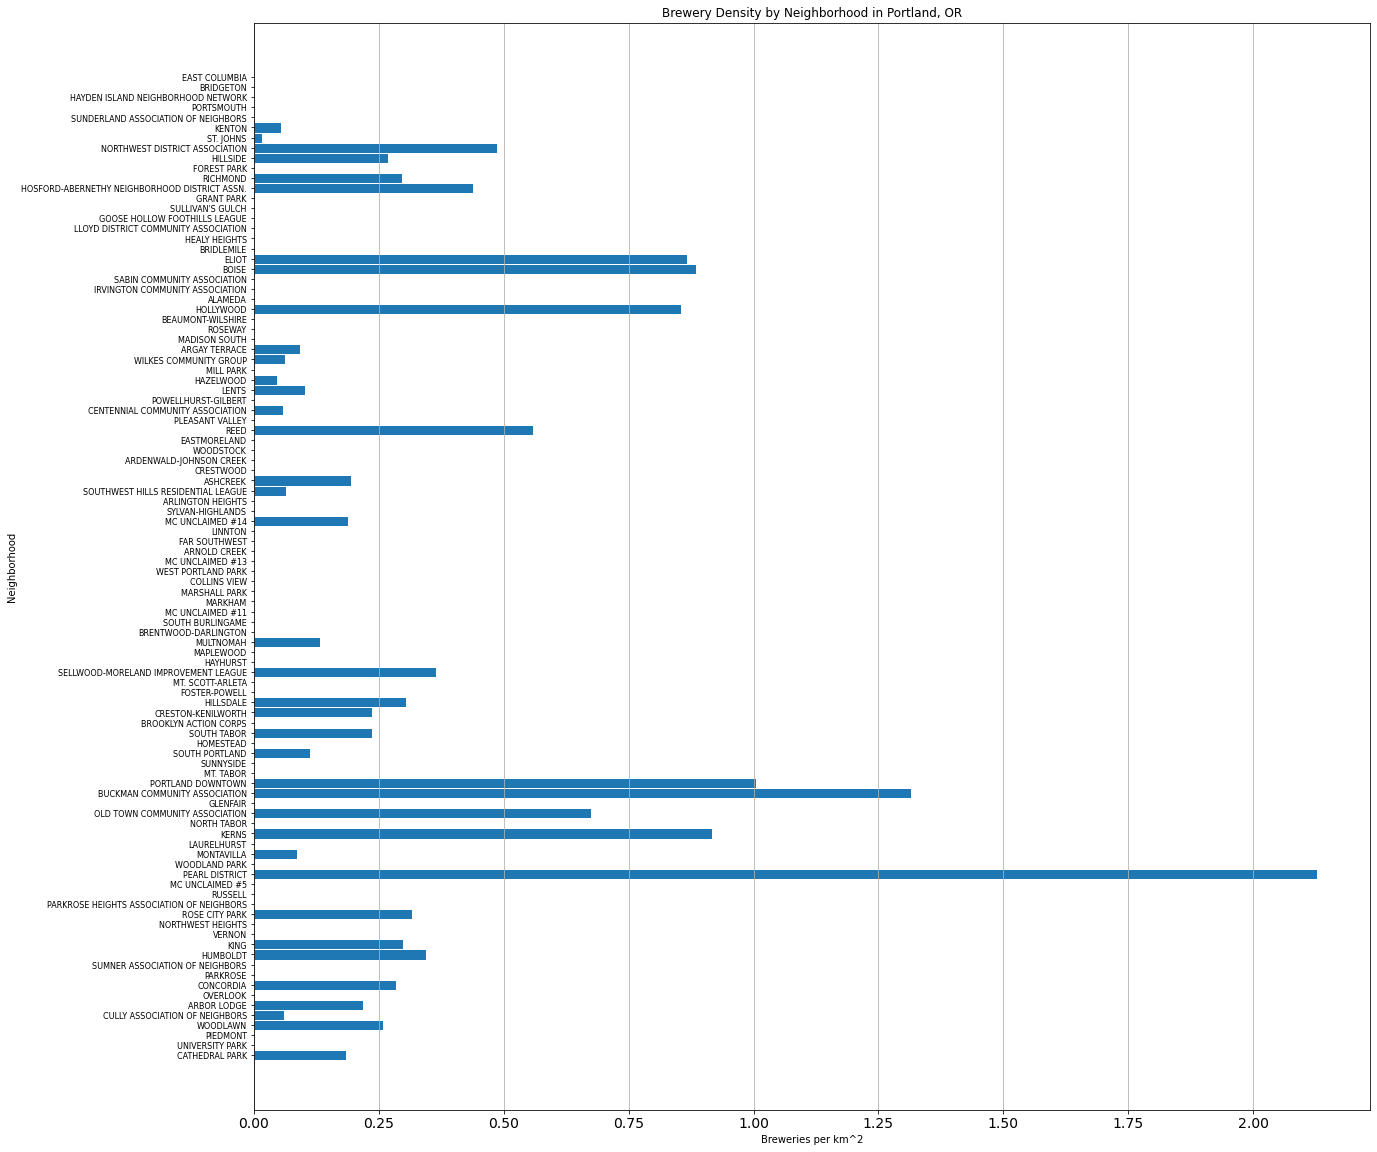

In [44]:
# Need to adjust figure size to account for large number of neighborhoods
f = plt.figure() 
f.set_figwidth(20) 
f.set_figheight(20)
# Add vertical grid lines for clarity
plt.grid(axis = 'x')
plt.barh(hoods_and_brews['NAME'], 
         hoods_and_brews['brew_density'], 
         height = 1, 
         ec = 'white'
         )
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=8, rotation=0)
plt.xlabel('Breweries per km^2')
plt.ylabel('Neighborhood')
plt.title('Brewery Density by Neighborhood in Portland, OR')

plt.show()

In [45]:
# Center point for Portland is stored in the 'location' variable
# Therefore no need to re-create

# Create map
m = folium.Map(location=location, zoom_start=12)

# Build choropleth
m.choropleth(
    geo_data=hoods_and_brews,
    name='Neighborhoods',
    data=hoods_and_brews,
    columns=['NAME', 'brew_density'],
    key_on='feature.properties.NAME',
    fill_color='BuGn',
    fill_opacity=0.85,
    line_opacity=1.0,
    legend_name='Portland Neighborhoods - Breweries per square kilometer'
)

# Create 'center' column containing the centroid of each neighborhood
hoods_and_brews['center'] = hoods_and_brews.geometry.centroid

# Build markers at the center of each neighborhood with popups
for row in hoods_and_brews.iterrows():
    row_values = row[1] 
    center_point = row_values['center']
    loc = [center_point.y, center_point.x]
    popup = ('Neighborhood: ' + str(row_values['NAME']) + 
             ';  ' + 'Breweries per km^2: ' + str(row_values['brew_density']))
    marker = folium.Marker(location = loc, popup = popup)
    marker.add_to(m)

# Create LayerControl and add it to the map            
folium.LayerControl().add_to(m)

# Display the map
display(m)   


/usr/local/lib/python3.6/dist-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



If we go through and check the group of brewery-dense neighborhoods, we can see that the Pearl District has the most breweries per square kilometer, at 2.13. However, there are a couple of close contenders in near proximity, and they all surround another neighborhood which has 0 breweries of its own. Buckman Community Association (South East of the Pearl District) has 1.31 Breweries per square kilometer, and Portland Downtown (South of the Pearl District) has 1.01 breweries per square kilometer. 

As mentioned above, there is a fourth neighborhood which is surrounded by the three mentioned above which has zero breweries of its own. The Old Town Community Association has zero breweries, but would provide easy walking to three of the most brewery-dense neighborhoods in all of Portland.

## Brewery Size/Type
It may be informative to take a look at some of the other information provided in the OpenBreweryDB dataset. For example, one of the datapoints provided is 'brewery type'. Generally speaking, smaller breweries tend to be more willing to take risks with innovation, and therefore have more interesting beers available. A beer tourist would probably be more interested in visiting a small brewery than a larger brewery. In addition to the reason listed above, there is also the simple fact that small breweries often don't have distribution beyond a small area.

In [46]:
# First we'll take a look at the available data from the breweries dataset
print(breweries.columns)

Index(['id', 'name', 'brewery_type', 'street', 'address_2', 'address_3',
       'city', 'state', 'county_province', 'postal_code', 'website_url',
       'phone', 'created_at', 'updated_at', 'country', 'longitude', 'latitude',
       'tags', 'geometry'],
      dtype='object')


In [47]:
# Now let's take a look at the types of entries in the 'brewery_type' column
print(breweries['brewery_type'].unique())

['large' 'brewpub' 'micro' 'contract' 'regional' 'proprietor']


We will now do a new version of our first visualization, with each brewery marker including the brewery type.

In [48]:
# Center point for Portland is stored in the 'location' variable
# Therefore no need to re-create

gdf = geometry.to_crs("EPSG:4326") 
m = folium.Map(location=location, zoom_start=12)
folium.GeoJson(data=gdf["geometry"]).add_to(m) 

# First we will create a color map
colormap = {'proprietor': 'darkgreen', 'brewpub': 'green', 
            'micro': 'lightgreen', 'large': 'gray', 'regional': 'lightgray', 
            'contract': 'black'}
for i in range(0, len(breweries.index)):
  # Find the color string for the current selection
  mcolor = colormap[breweries.iloc[i]['brewery_type']]
  # Find the brewery name and type for the current selection
  bname = breweries.iloc[i]['name']
  btype = breweries.iloc[i]['brewery_type']
  # Combine the brewery name and type into a string for the popup value
  popup = bname + '\n' + '(' + btype + ')'
  folium.Marker(location=[breweries.iloc[i]['latitude'], 
                          breweries.iloc[i]['longitude']], 
                          popup=popup, icon=folium.Icon(color=mcolor)
                          ).add_to(m)

m


## Clustering the Breweries
We will use agglomerative clustering to cluster the breweries geographically. This will allow us to compare general regions of Portland, not just neighborhoods. 

In [49]:
from sklearn.cluster import AgglomerativeClustering

# creates 9 clusters using hierarchical clustering.
agc = AgglomerativeClustering(n_clusters =9, 
                              affinity='euclidean', 
                              linkage='ward')
breweries['brew cluster'] = agc.fit_predict(breweries[['latitude','longitude']])

Since the clusters are numbered with integer values, we need to convert the cluster column to string values.

In [50]:
# Turn the 'brew cluster' column values into strings
breweries['brew cluster'] = breweries['brew cluster'].apply(str)

Now to visualize the clusters!

In [51]:
# Center point for Portland is stored in the 'location' variable

gdf = geometry.to_crs("EPSG:4326") 
m = folium.Map(location=location, zoom_start=12)
folium.GeoJson(data=gdf["geometry"]).add_to(m) 

# First we will create a color map. One for each cluster.
colormap = {'0': 'red', '1': 'green', '2': 'blue', '3': 'lightgray', 
            '4': 'purple', '5': 'orange', '6': 'lightgreen', '7': 'pink', 
            '8': 'lightblue'}
for i in range(0, len(breweries.index)):
  # Find the color string for the current selection
  mcolor = colormap[breweries.iloc[i]['brew cluster']]
  # Find the brewery name and type for the current selection
  bname = breweries.iloc[i]['name']
  btype = breweries.iloc[i]['brewery_type']
  bcluster = breweries.iloc[i]['brew cluster']
  # Combine the brewery name and type into a string for the popup value
  popup = bname + '\n' + '(' + btype + ')' + '\n' + bcluster
  folium.Marker(location=[breweries.iloc[i]['latitude'], 
                          breweries.iloc[i]['longitude']], 
                          popup=popup, 
                          icon=folium.Icon(color=mcolor)
                          ).add_to(m)

m

In [52]:
# Get average latitude values for the clusters
brewlat = breweries.groupby(['brew cluster']).mean(['latitude'])
brewlat['cluster'] = brewlat.index
brewlat = brewlat[['cluster', 'latitude']]

# Get average longitude values for the clusters
brewlong = breweries.groupby(['brew cluster']).mean(['longitude'])
brewlong['cluster'] = brewlong.index
brewlong = brewlong[['cluster', 'longitude']]

# Combine average latitude and longitude values in a single dataframe
brewzones = brewlat.merge(brewlong, on = 'cluster', how = 'outer')

# Print to check results
print(brewzones)

  cluster   latitude   longitude
0       0  45.530928 -122.685675
1       1  45.476837 -122.713829
2       2  45.566890 -122.663764
3       3  45.535431 -122.500949
4       4  45.517195 -122.651694
5       5  45.589307 -122.756949
6       6  45.494671 -122.580494
7       7  45.479379 -122.647694
8       8  45.543104 -122.612747


Now we can map the clusters, with the cluster centers marked in black.

In [53]:
# Center point for Portland is stored in the 'location' variable

gdf = geometry.to_crs("EPSG:4326") 
m = folium.Map(location=location, zoom_start=12)
folium.GeoJson(data=gdf["geometry"]).add_to(m) 

# First we will create a color map. One for each cluster.
colormap = {'0': 'red', '1': 'green', '2': 'blue', '3': 'lightgray', 
            '4': 'purple', '5': 'orange', '6': 'lightgreen', '7': 'pink', 
            '8': 'lightblue'
            }

for i in range(0, len(breweries.index)):
  # Find the color string for the current selection
  mcolor = colormap[breweries.iloc[i]['brew cluster']]
  # Find the brewery name and type for the current selection
  bname = breweries.iloc[i]['name']
  btype = breweries.iloc[i]['brewery_type']
  bcluster = breweries.iloc[i]['brew cluster']
  tooltip = folium.Tooltip(mcolor)
  # Combine the brewery name and type into a string for the popup value
  popup = bname + '\n' + '(' + btype + ')' + '\n' + bcluster
  folium.Marker(location=[breweries.iloc[i]['latitude'], 
                          breweries.iloc[i]['longitude']], 
                          popup=popup, 
                          icon=folium.Icon(color=mcolor)
                          ).add_to(m)

for i in range(0, len(brewzones.index)):
  # Find the color string for the current selection
  mcolor = colormap[brewzones.iloc[i]['cluster']]
  # Find the brewery name and type for the current selection
  bcluster = brewzones.iloc[i]['cluster']
  # Combine the brewery name and type into a string for the popup value
  popup = 'Cluster # ' + bcluster
  folium.Marker(location=[brewzones.iloc[i]['latitude'], 
                          brewzones.iloc[i]['longitude']], 
                          popup=popup, 
                          icon=folium.Icon(color='black')
                          ).add_to(m)

m

<p align="center">
  <b>Brewery Clusters in Portland, Oregon:</b><br>

RED|GREEN|BLUE|LIGHT GRAY|PURPLE|ORANGE|LIGHT GREEN|PINK|LIGHT BLUE|BLACK
:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:
Cluster #0|Cluster #1|Cluster #2| Cluster #3|Cluster #4|Cluster #5|Cluster #6|Cluster #7|Cluster #8|Cluster Centroid

<br>
<br>


### Finding the 'best' beer neighborhoods in PDX
In order to find the optimal neighborhood to stay in, we should match each cluster centroid to a specific neighborhood. Once we decide which cluster of breweries to focus on for this trip, we can then search the vacation rental portal of our choosing (vrbo, airbnb, couchsurfing, etc) in the best neighborhood for that particular cluster. 

Just by glancing at the map above, we can tell that cluster #0 (RED) and cluster #4 (PURPLE) are the one's most attractive to beer tourists.

In [54]:
print(gdf.columns)

Index(['OBJECTID', 'NAME', 'COMMPLAN', 'SHARED', 'COALIT', 'HORZ_VERT',
       'MAPLABEL', 'ID', 'Shape_Length', 'Shape_Area', 'geometry'],
      dtype='object')


In [56]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

# Iterate through rows of neighborhoods and brewery cluster centroids
for i in range(0, len(gdf.index)):
  polygon = Polygon(gdf.iloc[i]['geometry'])
  for j in range(0, len(brewzones.index)):
    point = Point(brewzones.iloc[j]['longitude'], brewzones.iloc[j]['latitude'])
    # Check if the neighborhood contains the centroid of the brewery cluster
    if polygon.contains(point):
      hood = gdf.iloc[i]['NAME']
      cluster = str(brewzones.iloc[j]['cluster'])
      print(hood + ' is in cluster #' + cluster + '\n')
      
# NOTE - Error due to cluster #3 being a multi-part geometry
#        It works out ok since it is the only one and can be checked manually

CATHEDRAL PARK is in cluster #5

PIEDMONT is in cluster #2

ROSE CITY PARK is in cluster #8

PEARL DISTRICT is in cluster #0

BUCKMAN COMMUNITY ASSOCIATION is in cluster #4

FOSTER-POWELL is in cluster #6

SELLWOOD-MORELAND IMPROVEMENT LEAGUE is in cluster #7

HAYHURST is in cluster #1



NotImplementedError: ignored

### Note:
We got an error in the geometry for the neighborhood containing the centroid for Cluster #3. Due to the lack of interest of that particular cluster (it only has 5 breweries, and they are the most geographically dispersed of all the clusters), we will ignore it for now. Regardless, the centroid is very apparently within a specific neighborhood.

(The neighborhood that this centroid falls in is the **Wilkes Community Group**)

In [57]:
# Create a list of only the 'best' neighborhoods
best_hoods = ['CATHEDRAL PARK', 'PIEDMONT', 'ROSE CITY PARK', 'PEARL DISTRICT', 
              'BUCKMAN COMMUNITY ASSOCIATION', 'FOSTER-POWELL', 
              'SELLWOOD-MORELAND IMPROVEMENT LEAGUE', 'HAYHURST', 
              'WILKES COMMUNITY GROUP']

# Only select the geometry for the 'best' neighborhoods
hoods_geo = gdf[gdf['NAME'].isin(best_hoods)]

m = folium.Map(location=location, zoom_start=12)
folium.GeoJson(data=hoods_geo["geometry"]).add_to(m) 

# First we will create a color map. One for each cluster.
colormap = {'0': 'red', '1': 'green', '2': 'blue', '3': 'lightgray', 
            '4': 'purple', '5': 'orange', '6': 'lightgreen', '7': 'pink', 
            '8': 'lightblue'}
for i in range(0, len(breweries.index)):
  # Find the color string for the current selection
  mcolor = colormap[breweries.iloc[i]['brew cluster']]
  # Find the brewery name and type for the current selection
  bname = breweries.iloc[i]['name']
  btype = breweries.iloc[i]['brewery_type']
  bcluster = breweries.iloc[i]['brew cluster']
  # Combine the brewery name and type into a string for the popup value
  popup = bname + '\n' + '(' + btype + ')' + '\n' + bcluster
  folium.Marker(location=[breweries.iloc[i]['latitude'], 
                          breweries.iloc[i]['longitude']], 
                          popup=popup, 
                          icon=folium.Icon(color=mcolor)
                          ).add_to(m)

m


### Conclusion
Now we've narrowed things down quite a bit! Time to start planning our trip to Portland. The Pearl District and Buckman Community Association seem to be the two best neighborhoods - the true winner would probably be based on personal preference and a couple of other factors (available lodging, other venues in the area, transportation, etc). 